# Xenium Fetal Lung 2 (Xenium Ranger) Processing

This notebook adapts the `Xenium_human_lung.ipynb` workflow for Xenium Ranger-style outputs located in:

- `/Volumes/processing2/fetal_lung2/*_xenium_output/outs`

Pipeline summary:

1. Discover and load all run folders.
2. Merge runs into one AnnData object with per-run metadata.
3. Run QC, filtering, normalization, PCA/UMAP, and Leiden clustering.
4. Add spatial coordinates and inspect spatial cluster structure.
5. Export clustered object and marker-gene tables.


## 1) Imports and plotting defaults

In [3]:
import os
import warnings
from pathlib import Path

# Helps avoid cache-path issues in constrained environments.
os.environ.setdefault("NUMBA_CACHE_DIR", "/tmp/numba_cache")
os.environ.setdefault("MPLCONFIGDIR", "/tmp/matplotlib")

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 2
sc.set_figure_params(dpi=110, facecolor="white")


## 2) Configure input/output paths

In [2]:
BASE_DIR = Path('/Volumes/processing2/fetal_lung2')
OUTPUT_DIR = BASE_DIR / 'derived_scanpy'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

RAW_PATH = OUTPUT_DIR / 'fetal_lung2_raw.h5ad'
CLUSTERED_PATH = OUTPUT_DIR / 'fetal_lung2_clustered.h5ad'
MARKER_TABLE_PATH = OUTPUT_DIR / 'fetal_lung2_markers_leiden_1.0.csv'

print('BASE_DIR:', BASE_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)


BASE_DIR: /Volumes/processing2/fetal_lung2
OUTPUT_DIR: /Volumes/processing2/fetal_lung2/derived_scanpy


## 3) Discover Xenium Ranger run directories

Expected structure per run:

- `run_name_xenium_output/outs/cell_feature_matrix.h5`
- `run_name_xenium_output/outs/cells.csv.gz`


In [3]:
run_dirs = [
    p for p in sorted(BASE_DIR.glob('*_xenium_output'))
    if p.is_dir() and not p.name.startswith('._')
]

print(f'Found {len(run_dirs)} run directories:')
for p in run_dirs:
    print(' -', p.name)

if len(run_dirs) == 0:
    raise FileNotFoundError(f'No *_xenium_output directories found under {BASE_DIR}')


Found 2 run directories:
 - M-Goliath-A1_slide2_xenium_output
 - M-Goliath-B1_slide1_xenium_output


## 4) Load each run and align matrix + cell metadata

In [4]:
def load_xenium_ranger_run(run_dir: Path) -> sc.AnnData:
    outs = run_dir / 'outs'
    h5_path = outs / 'cell_feature_matrix.h5'
    cells_path = outs / 'cells.csv.gz'

    if not h5_path.exists() or not cells_path.exists():
        missing = [str(p.name) for p in [h5_path, cells_path] if not p.exists()]
        raise FileNotFoundError(f'{run_dir.name}: missing required files: {missing}')

    print(f'Loading {run_dir.name}')
    ad = sc.read_10x_h5(h5_path)

    # Xenium Ranger cells table usually has a `cell_id` column; fallback covers legacy index-export style.
    cell_info = pd.read_csv(cells_path)
    if 'cell_id' not in cell_info.columns:
        cell_info = pd.read_csv(cells_path, index_col=0).reset_index().rename(columns={'index': 'cell_id'})

    cell_info = cell_info.drop_duplicates(subset='cell_id', keep='first').set_index('cell_id')

    # Keep matrix order and drop any unmatched rows.
    shared = ad.obs_names[ad.obs_names.isin(cell_info.index)]
    dropped_from_matrix = ad.n_obs - len(shared)
    dropped_from_cells = cell_info.shape[0] - len(shared)

    if dropped_from_matrix > 0:
        print(f'  - dropping {dropped_from_matrix} matrix barcodes not found in cells.csv.gz')
    if dropped_from_cells > 0:
        print(f'  - ignoring {dropped_from_cells} cells.csv.gz rows not found in matrix')

    ad = ad[shared].copy()
    ad.obs = cell_info.loc[shared].copy()

    run_name = run_dir.name
    sample_id = run_name.removesuffix('_xenium_output')

    ad.obs['run'] = run_name
    ad.obs['sample_id'] = sample_id
    ad.obs['cell_id'] = shared.astype(str)

    # Guarantee unique obs names across runs after concatenation.
    ad.obs_names = pd.Index([f'{sample_id}:{cid}' for cid in shared], name='obs_id')

    ad.var_names_make_unique()
    return ad

ad_list = []
for run_dir in run_dirs:
    try:
        ad_run = load_xenium_ranger_run(run_dir)
        print(f'  -> loaded {ad_run.n_obs:,} cells x {ad_run.n_vars:,} genes')
        ad_list.append(ad_run)
    except FileNotFoundError as e:
        print('Skipping:', e)

if len(ad_list) == 0:
    raise RuntimeError('No runs were successfully loaded. Check input folder structure.')


Loading M-Goliath-A1_slide2_xenium_output
reading /Volumes/processing2/fetal_lung2/M-Goliath-A1_slide2_xenium_output/outs/cell_feature_matrix.h5
 (0:00:01)
  -> loaded 740,346 cells x 343 genes
Loading M-Goliath-B1_slide1_xenium_output
reading /Volumes/processing2/fetal_lung2/M-Goliath-B1_slide1_xenium_output/outs/cell_feature_matrix.h5
 (0:00:01)
  -> loaded 777,084 cells x 343 genes


## 5) Concatenate runs and preserve raw counts

In [5]:
ad = sc.concat(ad_list, join='outer', merge='same')
ad.var_names_make_unique()

# Keep raw integer-like counts before normalization.
ad.layers['counts'] = ad.X.copy()

print(ad)
ad.obs[['run', 'sample_id', 'cell_id']].head()


AnnData object with n_obs × n_vars = 1517430 × 343
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'run', 'sample_id', 'cell_id'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts'


,run,sample_id,cell_id
obs_id,,,
M-Goliath-A1_slide2:aaaabpbn-1,M-Goliath-A1_slide2_xenium_output,M-Goliath-A1_slide2,aaaabpbn-1
M-Goliath-A1_slide2:aaaacjga-1,M-Goliath-A1_slide2_xenium_output,M-Goliath-A1_slide2,aaaacjga-1
M-Goliath-A1_slide2:aaaaeekj-1,M-Goliath-A1_slide2_xenium_output,M-Goliath-A1_slide2,aaaaeekj-1
M-Goliath-A1_slide2:aaaafejn-1,M-Goliath-A1_slide2_xenium_output,M-Goliath-A1_slide2,aaaafejn-1
M-Goliath-A1_slide2:aaaagced-1,M-Goliath-A1_slide2_xenium_output,M-Goliath-A1_slide2,aaaagced-1


## 6) QC metrics and per-sample summary

In [6]:
sc.pp.calculate_qc_metrics(ad, percent_top=None, log1p=False, inplace=True)

qc_summary = (
    ad.obs.groupby('sample_id')
    .agg(
        n_cells=('cell_id', 'count'),
        mean_total_counts=('total_counts', 'mean'),
        median_total_counts=('total_counts', 'median'),
        mean_genes=('n_genes_by_counts', 'mean'),
        median_genes=('n_genes_by_counts', 'median'),
    )
    .sort_values('n_cells', ascending=False)
)

qc_summary


,n_cells,mean_total_counts,median_total_counts,mean_genes,median_genes
sample_id,,,,,
M-Goliath-B1_slide1,777084,122.321808,103.0,47.448917,46.0
M-Goliath-A1_slide2,740346,127.600746,107.0,48.073163,47.0


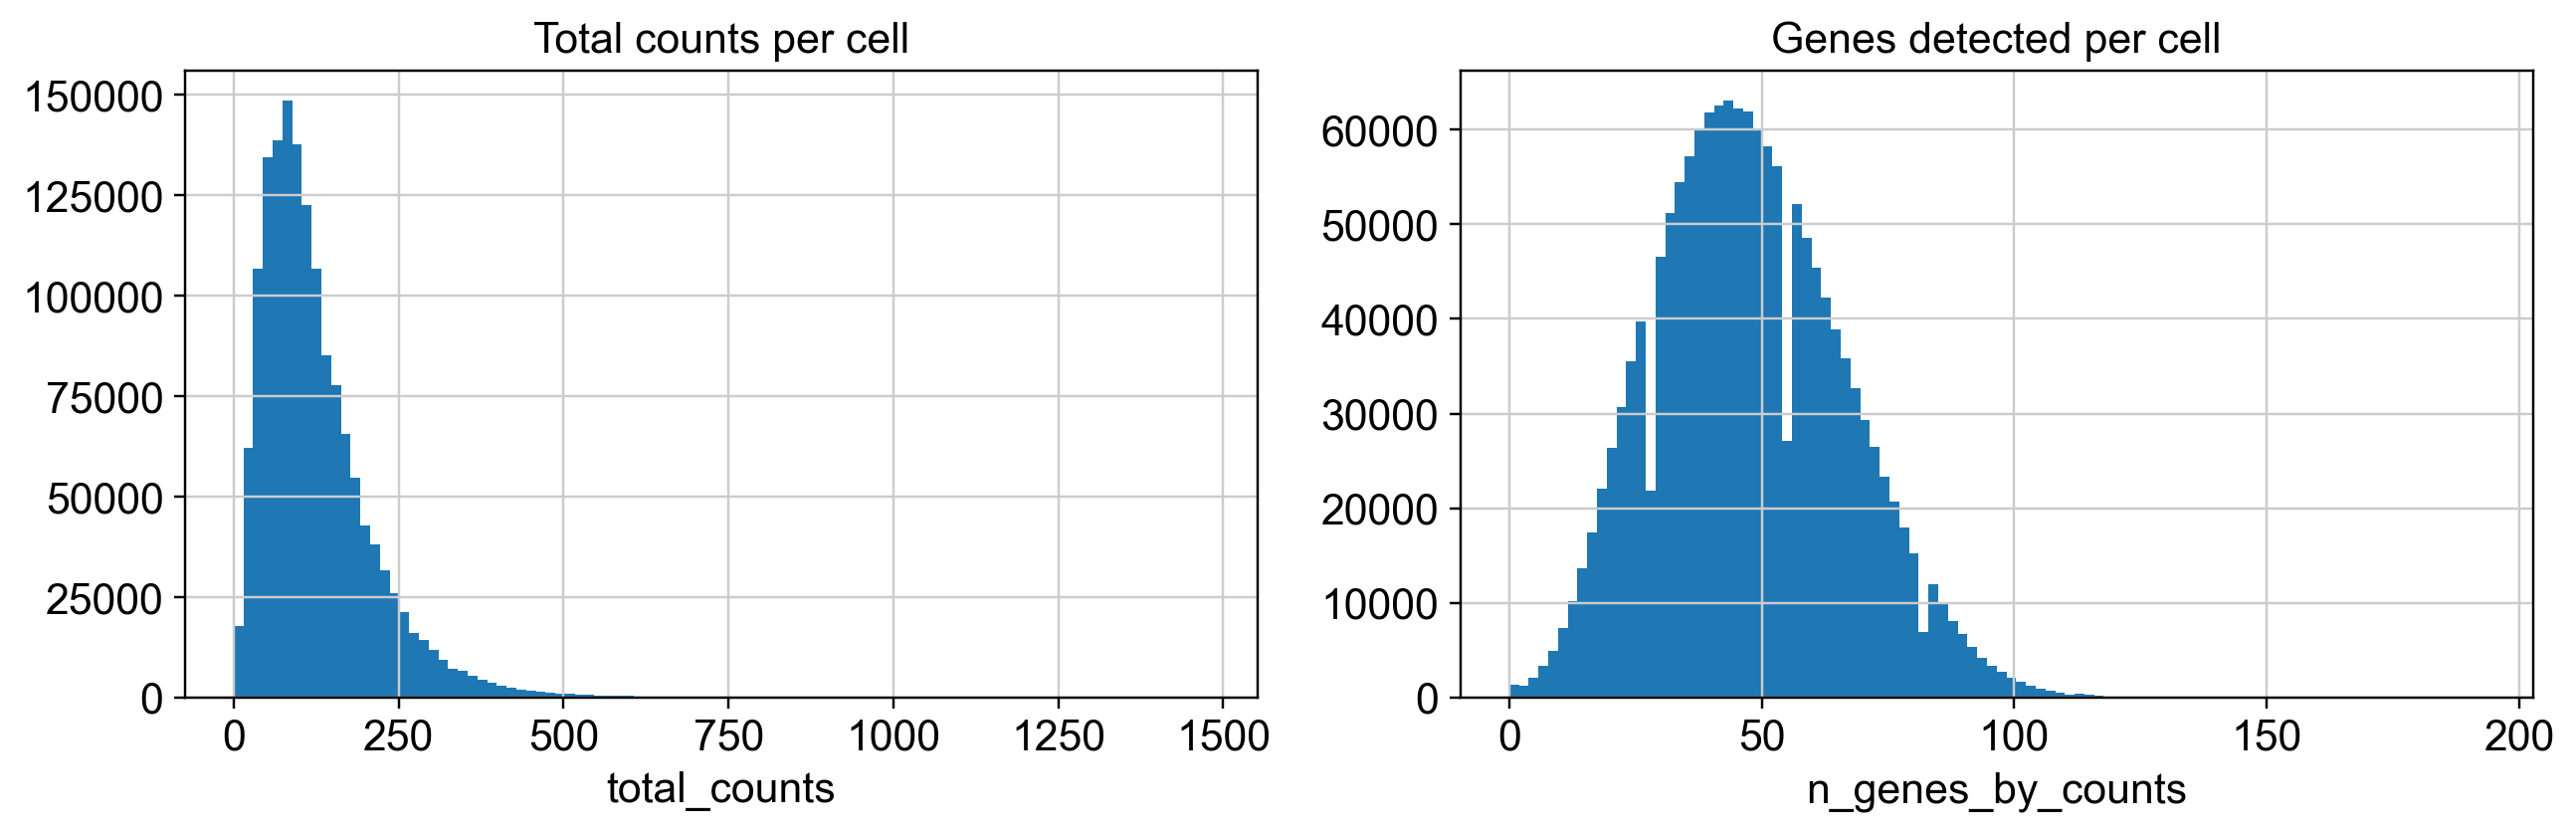

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ad.obs['total_counts'].hist(bins=100, ax=axes[0])
axes[0].set_title('Total counts per cell')
axes[0].set_xlabel('total_counts')

ad.obs['n_genes_by_counts'].hist(bins=100, ax=axes[1])
axes[1].set_title('Genes detected per cell')
axes[1].set_xlabel('n_genes_by_counts')

plt.tight_layout()


## 7) Save a raw checkpoint

In [8]:
ad.write(RAW_PATH)
print('Wrote:', RAW_PATH)


Wrote: /Volumes/processing2/fetal_lung2/derived_scanpy/fetal_lung2_raw.h5ad


In [4]:
ad = sc.read_h5ad(RAW_PATH)

## 8) Filter low-quality cells, normalize, and log-transform

In [5]:
# Match thresholds used in Xenium_human_lung.ipynb.
sc.pp.filter_cells(ad, min_counts=15)
sc.pp.filter_cells(ad, min_genes=5)

sc.pp.normalize_total(ad, target_sum=100)
sc.pp.log1p(ad)

print(ad)


filtered out 17905 cells that have less than 15 counts
filtered out 9 cells that have less than 5 genes expressed
normalizing counts per cell
    finished (0:00:00)
AnnData object with n_obs × n_vars = 1499516 × 343
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'run', 'sample_id', 'cell_id', 'n_genes_by_counts', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'


## 9) PCA, neighborhood graph, UMAP, and Leiden clustering

computing PCA
    with n_comps=50
    finished (0:00:16)


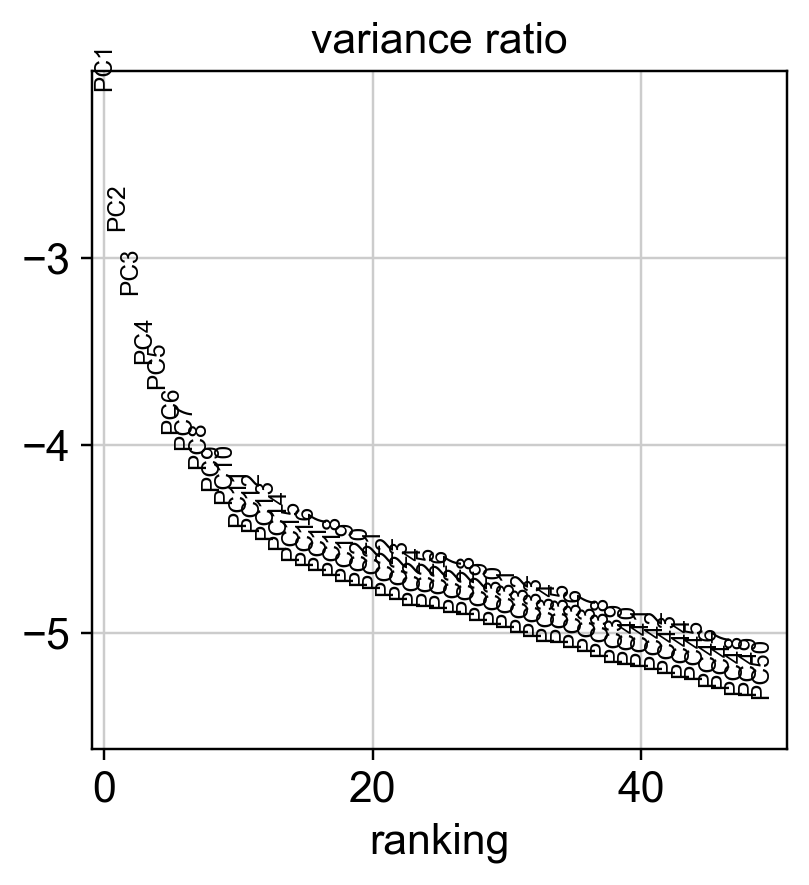

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:04:57)
computing UMAP


In [ ]:
sc.tl.pca(ad)
sc.pl.pca_variance_ratio(ad, n_pcs=50, log=True)

sc.pp.neighbors(ad, n_neighbors=15, n_pcs=30)
sc.tl.umap(ad, min_dist=0.1)

sc.pl.umap(ad, color=['sample_id'], s=1)


In [ ]:
resolutions = [1.0]

for resolution in resolutions:
    key = f'leiden_{resolution}'
    if key not in ad.obs.columns:
        sc.tl.leiden(ad, resolution=resolution, key_added=key)
    sc.pl.umap(ad, color=key, legend_loc='on data', frameon=False)


## 10) Add spatial coordinates and inspect spatial cluster maps

In [ ]:
ad.obsm['spatial'] = ad.obs[['x_centroid', 'y_centroid']].to_numpy()

# Global map
sc.pl.embedding(ad, basis='spatial', color=['sample_id', 'leiden_1.0'], s=2, frameon=False)


In [ ]:
# Per-sample spatial cluster maps
for sid in sorted(ad.obs['sample_id'].unique()):
    ad_sub = ad[ad.obs['sample_id'] == sid].copy()
    sc.pl.embedding(
        ad_sub,
        basis='spatial',
        color='leiden_1.0',
        title=f'{sid} (leiden_1.0)',
        s=2,
        frameon=False,
    )


## 11) Marker genes for cluster interpretation

In [ ]:
cluster_key = 'leiden_1.0'

sc.tl.rank_genes_groups(ad, groupby=cluster_key, method='t-test')
sc.pl.rank_genes_groups(ad, n_genes=25, sharey=False)

markers = sc.get.rank_genes_groups_df(ad, group=None)
markers = markers.sort_values(['group', 'logfoldchanges'], ascending=[True, False])
markers.head()


In [ ]:
top_markers = markers.groupby('group').head(30)
top_markers.to_csv(MARKER_TABLE_PATH, index=False)
print('Wrote marker table:', MARKER_TABLE_PATH)


## 12) Save clustered AnnData

In [ ]:
ad.write(CLUSTERED_PATH)
print('Wrote:', CLUSTERED_PATH)


In [ ]:
# Find HVGs
sc.pp.highly_variable_genes(
    ad,
    n_top_genes=50,
    flavor="seurat_v3"
)


In [ ]:
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything

seed_everything(12345)
scvi.settings.seed = 12345

Seed set to 12345
Seed set to 12345


In [ ]:
scvi.model.SCVI.setup_anndata(
    ad, 
    layer="counts", 
    batch_key='sample_id',
)

model = scvi.model.SCVI(ad)

In [ ]:
model.train(early_stopping=True, enable_progress_bar=True, max_epochs = 30)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Epoch 12/30:  37%|███▋      | 11/30 [16:26<34:50, 110.02s/it, v_num=1, train_loss=127]

In [ ]:
ad.obsm['X_scVI'] = model.get_latent_representation(ad).astype(np.float32)


In [ ]:
sq.gr.spatial_neighbors(ad, library_key='sample_id', coord_type='generic', delaunay=True, percentile=99)


In [ ]:
cc.gr.remove_long_links(ad)


In [ ]:
cc.gr.aggregate_neighbors(ad, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample_id')


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


In [ ]:
# GMM components to try
# GMM components to try
gmm_components = [10, 15,20]



In [ ]:
from sklearn.mixture import GaussianMixture
import pandas as pd

X = ad.obsm['X_cellcharter']
gmm_results = []

for k in gmm_components:
    print(k)
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0,
        n_init=3,
    )
    labels = gmm.fit_predict(X)
    key = f'CellCharter_{k}'
    ad.obs[key] = labels.astype(str)
    gmm_results.append({
        'k': k,
        'bic': gmm.bic(X),
        'aic': gmm.aic(X),
    })
    n_clusters = ad.obs[key].nunique()
    print(f'k={k}: {n_clusters} clusters')


10
k=10: 10 clusters
15
k=15: 15 clusters
20
k=20: 20 clusters


In [ ]:
import sys
sys.path.append("/Users/chrislangseth/work/karolinska_institutet/projects/BaloMS/")
from utils import spatial_utils

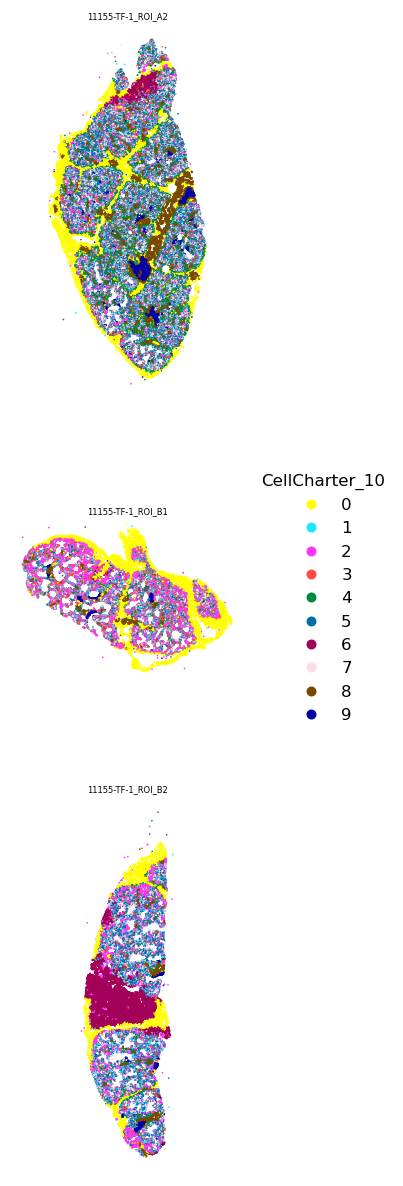

In [ ]:
spatial_utils.plot_spatial_compact_fast(
    ad,
    color="CellCharter_10",
    groupby="sample_id",
    spot_size=1,
    cols=1,
    height=10,
    background="white",
    dpi=120,
)
